# 압축 해제

In [2]:
!unzip '*.zip'

Archive:  VL1.zip
   creating: json/
   creating: json/11/
  inflating: json/11/10123.json      
  inflating: json/11/10259.json      
  inflating: json/11/10263.json      
  inflating: json/11/10264.json      
  inflating: json/11/10350.json      
  inflating: json/11/10351.json      
  inflating: json/11/10352.json      
  inflating: json/11/10353.json      
  inflating: json/11/10354.json      
  inflating: json/11/10442.json      
  inflating: json/11/10443.json      
  inflating: json/11/10450.json      
  inflating: json/11/10451.json      
  inflating: json/11/10452.json      
  inflating: json/11/10453.json      
  inflating: json/11/10454.json      
  inflating: json/11/10455.json      
  inflating: json/11/10456.json      
  inflating: json/11/10675.json      
  inflating: json/11/10684.json      
  inflating: json/11/10685.json      
  inflating: json/11/10694.json      
  inflating: json/11/10695.json      
  inflating: json/11/10696.json      
  inflating: json/11/10704.js

# 데이터셋 분석

In [3]:
import numpy as np
# import cv2
import matplotlib.pyplot as plt
import os
import json
import torch

## 데이터 로드

In [4]:
label_path = './json/'
dir_list = os.listdir(label_path)
# 폴더를 전부 순회하면서 파일의 이름 읽기

json_path = []
for dir_name in dir_list:
  dir_path = os.path.join(label_path,dir_name)
  json_path.extend([os.path.join(dir_path,x) for x in os.listdir(dir_path) if 'json' in x ])

In [5]:
# 파일 개수
len(json_path)

1218

In [6]:
def preprocess(json_file):
    '''
    1개의 json_file 파일을 분석해서 스켈레톤 데이터와 행동의 번호를 리턴하는 함수
    '''
    raw_data = json_file['sequence']['2d_pos']
    skeleton_data = np.array(raw_data,np.float32).reshape(-1,72) # 동영상 길이, 관절 개수 * 3
    label = np.array(json_file['info']['act_no'],np.int32)

    return skeleton_data,label

In [7]:
def pipeline(path):
    with open(path,'r') as f:
        data = json.load(f)
    return preprocess(data)

In [8]:
data, label = pipeline(json_path[0])

In [9]:
data.shape

(88, 72)

In [10]:
x = []
y = []
for file_path in json_path:
    data, label = pipeline(file_path)
    x.append(data)
    y.append(label)

In [11]:
y_data  = np.array(y)
y_data.shape

(1218,)

In [142]:
x_data = np.array(x)
# 이미지의 길이가 전부 다르기에 길이를 맞추는 작업이 필요함
x_data.shape

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1218,) + inhomogeneous part.

In [12]:
from torch.nn.utils.rnn import pad_sequence

# x는 여러 개의 길이가 다른 torch.Tensor로 이루어진 리스트여야 함
# 예: [tensor([10, 20, 30]), tensor([40, 50]), tensor([60])]

x_tensor_list = [torch.tensor(arr, dtype=torch.float32) for arr in x]  # x는 np.array 리스트라고 가정

# 패딩: default는 가장 긴 시퀀스에 맞춰서 0으로 뒤쪽(post) 패딩
x_data = pad_sequence(x_tensor_list, batch_first=True)  # shape: (배치, 시퀀스 길이, feature)

In [13]:
x_data.shape

torch.Size([1218, 203, 72])

In [14]:
# y_data의 숫자의 형태 분석
# 6개의 값으로 나뉘어져 있음
# True, True를 통해 6개중 어떤 데이터 가 N개 있는지 파악할수 있으며
# 마지막 True를 통해 어느 위치에 값이 있는지 분석 가능
# 해당 값을 이용해 11 -> 0 , 12-> 1로 바꿔 사용
np.unique(y_data,True,True)

(array([11, 12, 31, 32, 33, 43], dtype=int32),
 array([1015,  404,  607,    0,  812,  202]),
 array([3, 3, 3, ..., 0, 0, 0]))

In [15]:
_, _,y_data = np.unique(y_data,True,True)

In [16]:
y_data[::20]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [17]:
import torch
import torch.nn.functional as F

# 1. y_data가 numpy 배열이면 텐서로 변환
y_tensor = torch.from_numpy(y_data).long()

# 2. 클래스 개수
num_classes = torch.max(y_tensor).item() + 1

# 3. 원-핫 인코딩
y_data = F.one_hot(y_tensor, num_classes=num_classes).float()

In [18]:
y_data.shape

torch.Size([1218, 6])

In [19]:
y_data[::100]

tensor([[0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.]])

In [20]:
x_data[0][0][:3]

tensor([ 972.0270, 1378.4200,    0.0000])

In [21]:
x_data.shape

torch.Size([1218, 203, 72])

In [22]:
from sklearn.model_selection import train_test_split
# train 데이터와 valid, test데이터를 분할하여 학습에 활용

X_train, X_test, y_train, y_test = train_test_split(x_data,y_data,train_size=0.7,random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


(torch.Size([852, 203, 72]),
 torch.Size([366, 203, 72]),
 torch.Size([852, 6]),
 torch.Size([366, 6]))

# 모델 구성

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ActionLSTM(nn.Module):
    def __init__(self, input_size=72, hidden_size=100, num_classes=6):
        super(ActionLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: (batch_size, seq_len, 72)
        out, _ = self.lstm1(x)   # out shape: (batch_size, seq_len, hidden_size)
        out, _ = self.lstm2(out) # out shape: (batch_size, seq_len, hidden_size)
        out = out[:, -1, :]      # 시퀀스 중 마지막 타임스텝의 hidden state 사용
        out = self.fc(out)       # shape: (batch_size, num_classes)
        return out
model = ActionLSTM()

In [24]:
import torch.nn as nn

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 옵티마이저 정의 (예시)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
def model_summary_print(model, input_size):
    print(f"{'Layer (type)':<20}{'Output Shape':<25}{'Param #':<15}")
    print("=" * 60)

    x = torch.zeros(1, *input_size)
    total_params = 0

    for name, module in model.named_children():
        x = module(x)[0] if isinstance(module, nn.LSTM) else module(x)
        params = sum(p.numel() for p in module.parameters() if p.requires_grad)
        print(f"{name + ' (' + module.__class__.__name__ + ')':<20}{str(tuple(x.shape)):<25}{params:<15}")
        total_params += params

    print("=" * 60)
    print(f"Total params: {total_params}")

# 모델 생성 후 요약 출력
model = ActionLSTM()
model_summary_print(model, input_size=(50, 72))  # (sequence_length, input_size)

Layer (type)        Output Shape             Param #        
lstm1 (LSTM)        (1, 50, 100)             69600          
lstm2 (LSTM)        (1, 50, 100)             80800          
fc (Linear)         (1, 50, 6)               606            
Total params: 151006


In [26]:
from sklearn.model_selection import train_test_split

# 예: x_data, y_data는 이미 정제된 torch.Tensor 형태라고 가정
# y_data가 원-핫이면 미리 정수 인덱스로 바꿔야 함
# y_data = torch.argmax(y_data, dim=1)  ← 이건 필요할 경우만

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.7, random_state=42)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch

# ---------------------------
# 하이퍼파라미터
# ---------------------------
EPOCHS = 100
BATCH_SIZE = 32

# ---------------------------
# DataLoader 준비
# (y_train, y_test는 one-hot일 경우 argmax로 정수화해야 함)
# ---------------------------
y_train_idx = torch.argmax(y_train, dim=1)
y_test_idx = torch.argmax(y_test, dim=1)

train_dataset = TensorDataset(X_train, y_train_idx)
test_dataset = TensorDataset(X_test, y_test_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# ---------------------------
# 학습 기록용 리스트
# ---------------------------
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# ---------------------------
# 학습 루프
# ---------------------------
for epoch in range(EPOCHS):
    model.train()
    total_loss, correct = 0.0, 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == yb).sum().item()

    train_loss = total_loss / len(train_loader)
    train_acc = correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # -----------------------
    # 검증 루프
    # -----------------------
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == yb).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # -----------------------
    # 로그 출력
    # -----------------------
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/100 | Loss: 1.5588 | Acc: 0.3286 | Val Loss: 1.6704 | Val Acc: 0.2896
Epoch 2/100 | Loss: 1.5538 | Acc: 0.3157 | Val Loss: 1.6757 | Val Acc: 0.2377
Epoch 3/100 | Loss: 1.5469 | Acc: 0.3275 | Val Loss: 1.6698 | Val Acc: 0.2842
Epoch 4/100 | Loss: 1.5408 | Acc: 0.3157 | Val Loss: 1.6680 | Val Acc: 0.2978
Epoch 5/100 | Loss: 1.5407 | Acc: 0.3392 | Val Loss: 1.6666 | Val Acc: 0.3005
Epoch 6/100 | Loss: 1.5370 | Acc: 0.3474 | Val Loss: 1.6609 | Val Acc: 0.2842


In [28]:
print({
    "loss": train_losses,
    "val_loss": val_losses,
    "accuracy": train_accuracies,
    "val_accuracy": val_accuracies
}.keys())


dict_keys(['loss', 'val_loss', 'accuracy', 'val_accuracy'])


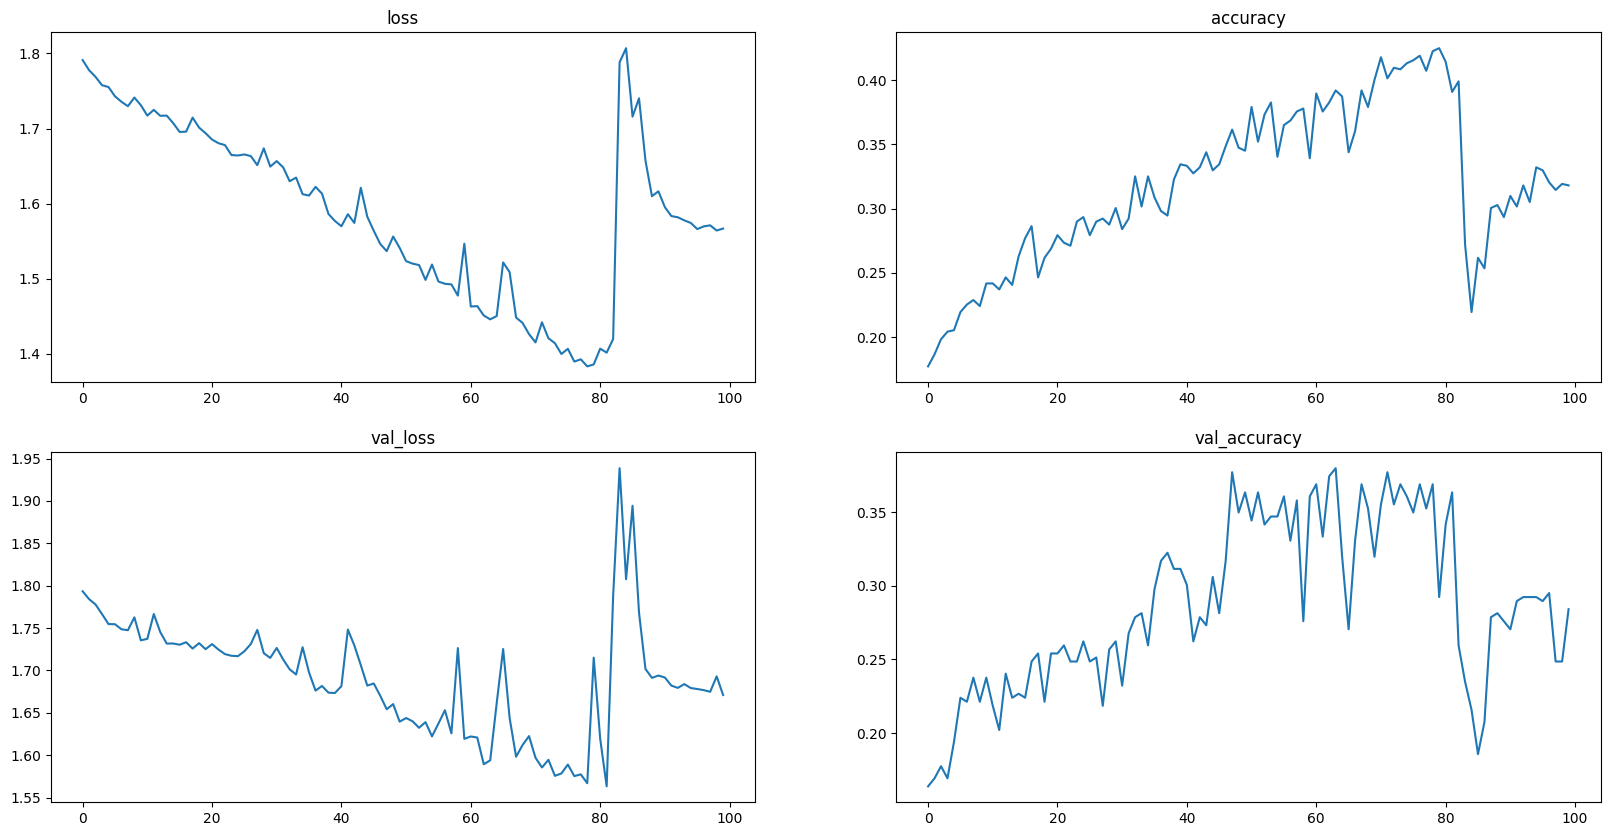

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.plot(train_losses)
plt.title('loss')

plt.subplot(2, 2, 2)
plt.plot(train_accuracies)
plt.title('accuracy')

plt.subplot(2, 2, 3)
plt.plot(val_losses)
plt.title('val_loss')

plt.subplot(2, 2, 4)
plt.plot(val_accuracies)
plt.title('val_accuracy')

plt.show()

In [32]:
# 평가 함수 정의
def evaluate_model(model, dataloader, criterion):
    model.eval()
    val_loss, val_correct = 0.0, 0

    with torch.no_grad():
        for xb, yb in dataloader:
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            val_correct += (preds == yb).sum().item()

    avg_loss = val_loss / len(dataloader)
    accuracy = val_correct / len(dataloader.dataset)
    return avg_loss, accuracy

# 테스트 데이터셋 평가
test_loss, test_acc = evaluate_model(model, val_loader, criterion)
print(f"📊 최종 테스트 Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f}")


📊 최종 테스트 Loss: 1.6710 | Accuracy: 0.2842
